In [1]:
from unmixing.utils import as_array
from unmixing.utils import pixel_to_xy
from unmixing.lsma import ravel_and_filter
from unmixing.transform import mnf_rotation
from unmixing.utils import array_to_raster, dump_raster
from unmixing.visualize import FeatureSpace
from unmixing.transform import mnf_rotation
from unmixing.lsma import convex_hull_graham
from unmixing.utils import spectra_at_xy
from unmixing.lsma import FCLSAbundanceMapper
from unmixing.lsma import endmembers_by_maximum_volume

import json

import pysptools.eea as sp_extract

import numpy as np
import pysptools.util as sp_utils

from matplotlib import pyplot as plt, cm
%matplotlib inline

from osgeo import gdal

## Image preprocessing

In the first steps, we explore the data and get rid of all other surface types that are not vegetation and perform a noise and dimensionality reduction.

In [50]:
# load UAV image as 3D NumPy array
image, gt, wkt = as_array('C:/Users/Henrike/test.tif')

tuple

GT returns the corner coordinates, pixel size, etc. of the raster

In [3]:
gt

(684544.7354229867,
 0.07000869820171894,
 0.0,
 9572983.114587901,
 0.0,
 -0.07000870104953134)

WKT is the Well-Known Text string describing the projection of the raster.

In [4]:
wkt

'PROJCS["WGS 84 / UTM zone 18S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32718"]]'

In [3]:
# Check the no data value of the image
file = 'C:/Users/Henrike/test.tif'
test0 = gdal.Open(file)
band = test0.GetRasterBand(1)
band.GetNoDataValue()

0.0

In [4]:
# Create new array that contains boolean of locations where image has no data values
img_na = np.any(image == 0.0, axis = 0)

In [5]:
# copy image to new array and set all zeros to 9999
arrImg = np.copy(image)
arrImg[:, img_na == True] = 9999

Here we use 9999 becasue otherwise the normalization throw an error.

In [19]:
# Convert array to gdal.Dataset (raster), dump to file
#dump_raster(array_to_raster(arrImg, gt, wkt), 'C:/Users/Henrike/SoftwareDev_Final/test_NoData_v3.tiff', nodata = np.NaN)

In [6]:
# create function to normalize image values between 0 and 1
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [ ]:
# apply function to image
scaled_image = NormalizeData(arrImg)
scaled_image.shape

(5, 3689, 6414)

In order to remove all other surface types that are not vegetation, we calculate the NDVI and set a threshold based on visual inspection in QGIS.

In [8]:
# Calculate NDVI
red = scaled_image[2]
nir = scaled_image[4]

ndvi = np.divide((nir - red), (nir + red))

In [16]:
#dump_raster(array_to_raster(ndvi, gt, wkt), 'C:/Users/Henrike/SoftwareDev_Final/NDVI.tiff', nodata = np.NaN)

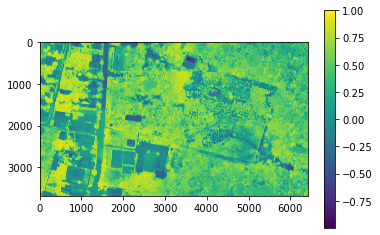

In [13]:
# plot NDVI
plt.imshow(np.squeeze(ndvi))   
plt.colorbar()

In [9]:
# Create classes and apply to NDVI results
ndvi_mask = np.where(ndvi > 0.4, ndvi, -9999) 
ndvi_mask.shape

(3689, 6414)

In [10]:
# Apply mask to scaled image
scaledImg_masked = np.copy(scaled_image)
scaledImg_masked[:, ndvi_mask == -9999] = -9999
scaledImg_masked.shape

(5, 3689, 6414)

In [32]:
#dump_raster(array_to_raster(scaledImg_masked, gt, wkt), 'C:/Users/Henrike/SoftwareDev_Final/test_NDVI_masked.tiff', nodata = np.NaN)

## Dimensionality Reduction

To reduce the noise and dimensionality of the UAV image, a minimum noise fraction (MNF) transformation is applied to the raster.

For further information, refer to https://github.com/arthur-e/unmixing/blob/master/docs/Overview_LSMA_in_Python.ipynb

In [11]:
hsi_post_mnf = mnf_rotation(scaledImg_masked)

In [20]:
#hsi_post_mnf.shape

(6414, 3689, 5)

In [24]:
#hsi_post_mnf.T.shape

(5, 3689, 6414)

In [12]:
# Dimensionailty reduction using eigenvalues
# Filter out NoData values from the MNF-transformed image
hsi_post_mnf_filtered = ravel_and_filter(np.where(scaledImg_masked == -9999, -9999, hsi_post_mnf.T))

# Obtain the covariance matrix
cov_m = sp_utils.cov(hsi_post_mnf_filtered)

# Compute the eigenvalues, sort them, reverse the sorting
eigenvals = np.sort(np.linalg.eig(cov_m)[0])[::-1]
eigenvals_p = np.power(eigenvals, 2) / sum(np.power(eigenvals, 2))
list(map(lambda x: round(x, 5), eigenvals_p.tolist()))

[0.98026, 0.0146, 0.00511, 2e-05, 0.0]

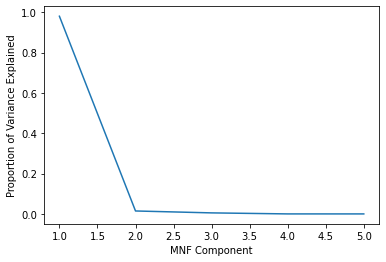

In [22]:
# plot components
plt.plot(range(1, 6), eigenvals_p)
plt.xlabel('MNF Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

The plot shows that the first component explains almost all the variance. This can also be seen in the following plot.

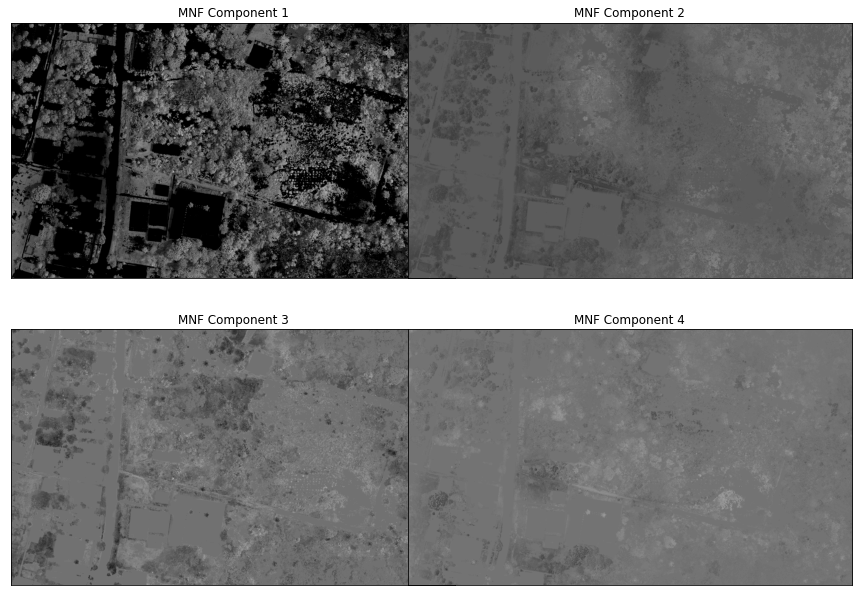

In [23]:
fig = plt.figure(figsize = (16, 16))
fig.subplots_adjust(wspace = -0.2)
for i in range(1, 5):
    ax = fig.add_subplot(320 + i, title = 'MNF Component %d' % i)
    ax.imshow(hsi_post_mnf.T[i - 1,:,:], cmap = cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Endmember extraction

In [13]:
ppi = sp_extract.PPI()

# Try to extract 3 endmembers using the PPI algorithm with 2,000 random projections
members = ppi.extract(hsi_post_mnf[...,0:3], 3, numSkewers = 2000)

In [14]:
ppi.get_idx()

# Switch pixel coordinates from (p, m, n) to (n, m, p)
coords = [(y, x) for x, y in ppi.get_idx()]

pixel_to_xy(coords, gt = gt, wkt = wkt, dd = True)

[(-3.8621155427946365, -73.3349053222192),
 (-3.8622766200768193, -73.33633139448148),
 (-3.8621168139382345, -73.33490784097056)]

In [16]:
# Convert array to gdal.Dataset (raster), dump to file
dump_raster(array_to_raster(scaledImg_masked, gt, wkt), 'C:/Users/Henrike/SoftwareDev_Final/test_arrayImage.tiff', nodata = -9999)

# Set feature_limit = None so that we see every pixel, not a random subset
vis_fs = FeatureSpace(path = 'C:/Users/Henrike/SoftwareDev_Final/test_arrayImage.tiff', nodata = -9999,
                      feature_limit = 10000)
vis_fs.plot_feature_space()

KeyboardInterrupt: 

## Endmember selection with Graham's Scan

In [17]:
# load potential endmembers that were selected in QGIS
with open('C:/Users/Henrike/SoftwareDev_Final/spectra2.json', 'r') as stream:
    veg_pifs = json.load(stream)
    

targets = veg_pifs.copy()
targets

{'veg1': [[684775.9192169374, 9572848.223057125]],
 'veg2': [[684747.5672692742, 9572904.071355322]],
 'veg3': [[684665.8533589365, 9572863.567877417]],
 'veg4': [[684707.5754868897, 9572832.283291796]],
 'dark': [[684737.6466550155, 9572833.687011149]]}

In [18]:
# Flatten the dictionary to a list
endmember_coords = []
for target in targets.keys():
    endmember_coords.extend(targets[target])
    
# A known shade endmember
shade_em = (684737.646655015530996, 9572833.687011148780584)
endmember_coords.append(shade_em)

In [19]:
# Get the MNF spectra for each potential endmember
endmember_spectra = spectra_at_xy(hsi_post_mnf.T, endmember_coords, gt, wkt, dd = False)

In [20]:
# Find endmembers using Graham's scan
idx, hull = convex_hull_graham(endmember_spectra[...,0:2].tolist(), indices = True)

In [21]:
# Get the coordinate pairs that appeared in the convex hull
hull_coords = [endmember_coords[i] for i in idx]

# A follow-up search by maximum volume
ems, em_coords = endmembers_by_maximum_volume(hsi_post_mnf.T, hull_coords, 
                                              shade_em, gt = gt, wkt = wkt)


## Now apply the LSMA to the Sentienl image

In [39]:
# laod image
s2, gt, wkt = as_array('C:/Users/Henrike/SoftwareDev_Final/S2_20200803_full.tiff')
s2.shape

(7, 10980, 10980)

In [ ]:
# reduce noise and dimensionality
mnf = mnf_rotation(s2)
fcls_mapper = FCLSAbundanceMapper(mnf.T, gt, wkt, processes = 6)

In [36]:
# apply fully contraint LSMA
result = fcls_mapper.map_abundance(ems)

In [37]:
ems.shape

(3, 3)

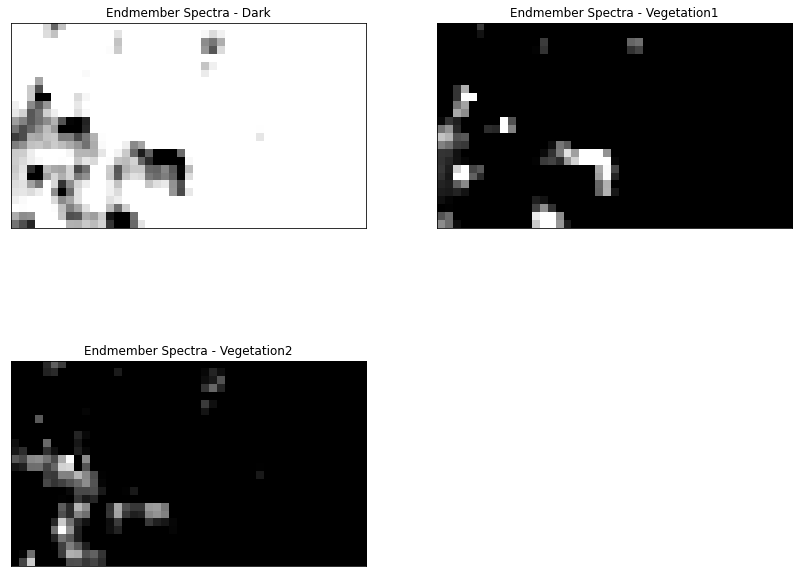

In [38]:
fig = plt.figure(figsize = (14, 14))
fig.subplots_adjust(hspace = -0.2)
endmember_labels = ['Dark', 'Vegetation1', 'Vegetation2']
for i in range(0, 3):
    ax = fig.add_subplot(221 + i, title = 'Endmember Spectra - %s' % endmember_labels[i])
    ax.imshow(result.T[i,...], cmap = cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)